<a href="https://colab.research.google.com/github/iMan0405/Portfolio_DT_vs_AI/blob/main/Sentiment_Analysis_for_Social_Media.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis modeli (Ijtimoiy tarmoq uchun)

### ushbu modelda twitter dataseti dan foydalanamiz va izohlarda qoldirilgan hissiyotlarni tahlil qilamiz:

Dataset haqida ma'lumot:
**textID** - matnning har bir qismi uchun noyob identifikator;
**text** - izoh matni;
**sentiment** - izohga berilgan hissiyot.

### birinchi navbatda kutubxonalarni yuklab olishimiz lozim

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

### Sentiment datasetini yuklab olamiz

In [3]:
df = pd.read_csv('/content/Tweets.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


### textID va selected_text ustunlarini o'chirib yuboramiz, shuningdek, yangi o'zgaruvchiga df ni saqlab olamiz

In [4]:
df.drop(['textID', 'selected_text'], axis = 1, inplace = True )
target = 'sentiment'
df.reset_index(drop = True, inplace = True)
original_df = df.copy(deep = True)
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [5]:
print("Ma'lumot to'plamlarining o'lchamlari: ", df.shape)
df.info()

Ma'lumot to'plamlarining o'lchamlari:  (27481, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


In [6]:
df.describe()

,text,sentiment
count,27480,27481
unique,27480,3
top,"I`d have responded, if I were going",neutral
freq,1,11118


### yuqorida holatda df ni tahlil qildik, va text ustunida 27480 ta, sentiment ustunida 27481 ta ma'lumot bor, demak text ustunida 1 ta null qiymat borligini bildiradi, buni bartaraf qilishimiz lozim

In [7]:
df.isnull().sum()

text         1
sentiment    0
dtype: int64

In [8]:
df.dropna(inplace = True)
original_df = df.copy()

### dulikatlarni tekshirib ko'ramiz

In [9]:
df.duplicated().sum()

0

### so'zlarni hisoblaymiz

In [10]:
df['world_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))
df[['text', 'world_count']].head()

,text,world_count
0,"I`d have responded, if I were going",8
1,Sooo SAD I will miss you here in San Diego!!!,11
2,my boss is bullying me...,5
3,what interview! leave me alone,6
4,"Sons of ****, why couldn`t they put them on t...",15


In [11]:
df['char_count'] = df['text'].str.len()
df[['text', 'char_count']].head()

,text,char_count
0,"I`d have responded, if I were going",36
1,Sooo SAD I will miss you here in San Diego!!!,46
2,my boss is bullying me...,25
3,what interview! leave me alone,31
4,"Sons of ****, why couldn`t they put them on t...",75


In [12]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words) / len(words))
df['avg_word'] = df['text'].apply(lambda x: avg_word(x))
df[['text', 'avg_word']].head()

,text,avg_word
0,"I`d have responded, if I were going",4.142857
1,Sooo SAD I will miss you here in San Diego!!!,3.600000
2,my boss is bullying me...,4.200000
3,what interview! leave me alone,5.200000
4,"Sons of ****, why couldn`t they put them on t...",4.357143


In [13]:
nltk.download('stopwords')
stop = stopwords.words('english')

df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['text', 'stopwords']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,stopwords
0,"I`d have responded, if I were going",3
1,Sooo SAD I will miss you here in San Diego!!!,4
2,my boss is bullying me...,2
3,what interview! leave me alone,2
4,"Sons of ****, why couldn`t they put them on t...",7


In [14]:
df['hastags'] = df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('@')]))
df[['text', 'hastags']].head()

,text,hastags
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


In [15]:
df['numerics'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df[['text', 'numerics']].head()

,text,numerics
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


## Wordcloud

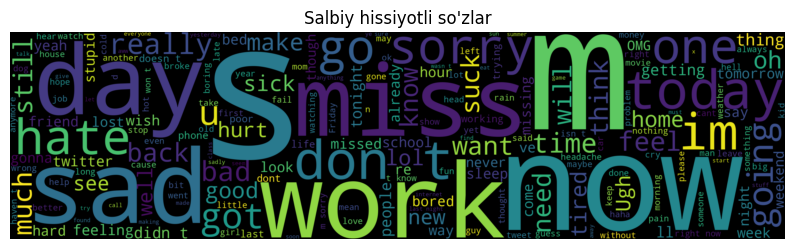

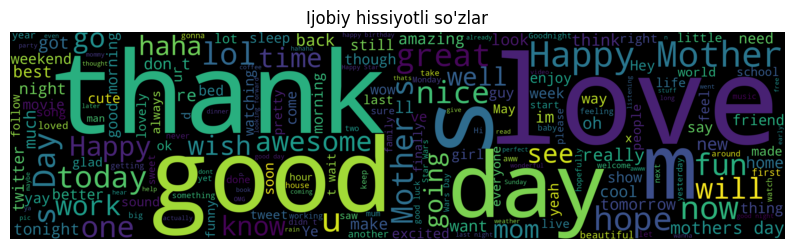

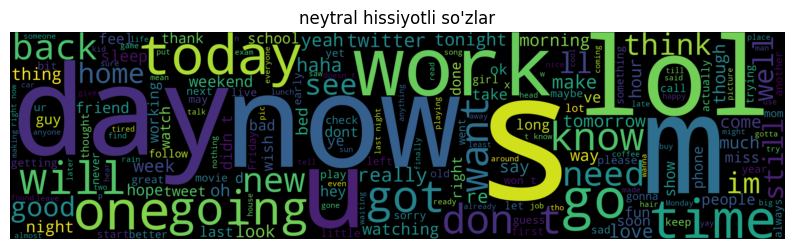

In [17]:
negative_df = df[df['sentiment'] == 'negative']
positive_df = df[df['sentiment'] == 'positive']
neutral_df = df[df['sentiment'] == 'neutral']

def generate_wordcloud(data, title):
  words = " ".join(data['text'])
  cleaned_word = " ".join([word for word in words.split()
                          if 'http' not in word
                           and not word.startswith('@')
                           and word != 'RT'])
  wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', width = 3000, height = 800).generate(cleaned_word)
  plt.figure(figsize = (10, 5))
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.title(title)
  plt.axis('off')
  plt.show()

generate_wordcloud(negative_df, "Salbiy hissiyotli so'zlar")
generate_wordcloud(positive_df, "Ijobiy hissiyotli so'zlar")
generate_wordcloud(neutral_df, "neytral hissiyotli so'zlar")